In [16]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision.utils import save_image

from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [17]:
# pip install albumentations

In [18]:
# set parameters
DEVICE = 'cuda'
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 50
SAVE_PER_EPOCHS = 1
SAVE_MODEL = True
LOAD_MODEL = False
CHECKPOINT_DISC = 'disc.pth.tar'
CHECKPOINT_GEN = 'gen.pth.tar'

In [19]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE),y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * .5 + .5 # remove normalization
        save_image(y_fake, folder + f'/y_gen_{epoch}.png')
        if epoch == 0:
            # only the first epoch will save label and input sketch
            save_image(y * .5 + .5, folder+ f'/label_{epoch}.png')
            save_image(x * .5 + .5, folder + f'/input_{epoch}.png')
    gen.train()

def save_checkpoint(model, optimizer, filename='my_checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    checkpoint = {
        'state_dict':model.state_dict(),
        'optimizer':optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print('=> Loading checkpoint')
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    # load saved checkpoint
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [20]:
# CNN block will be used repeatly later
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.conv(x)

In [21]:
# x, y <- concatenate the gen image and the input image to determin the gen image is real or not
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0],kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(.2)
        )
        
        # save layers into a list
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature
            
        # append last conv layer
        layers.append(
            nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect')
        )
        
        # create a model using the list of layers
        self.model = nn.Sequential(*layers)
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

In [22]:
# test the output of discriminator
x = torch.randn((1,3,256,256))
y = torch.randn((1,3,256,256))
model = Discriminator()
preds = model(x, y)
print(preds.shape)

torch.Size([1, 1, 26, 26])


In [23]:
# block will be use repeatly later
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            # the block will be use on both encoder (down=True) and decoder (down=False)
            nn.Conv2d(in_channels, out_channels, 4,2,1,bias=False, padding_mode='reflect')
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4,2,1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == 'relu' else nn.LeakyReLU(.2)
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(.5)
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [24]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        # Encoder
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4,2,1, padding_mode='reflect'),
            nn.LeakyReLU(.2),
        )
        self.down1 = Block(features, features*2, down=True,act='leaky',use_dropout=False) #64
        self.down2 = Block(features*2, features*4, down=True,act='leaky',use_dropout=False) #32
        self.down3 = Block(features*4, features*8, down=True,act='leaky',use_dropout=False) #16
        self.down4 = Block(features*8, features*8, down=True,act='leaky',use_dropout=False) #8
        self.down5 = Block(features*8, features*8, down=True,act='leaky',use_dropout=False) #4
        self.down6 = Block(features*8, features*8, down=True,act='leaky',use_dropout=False) #2
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4,2,1,padding_mode='reflect'),
            nn.ReLU(), # 1x1
        )
        # Decoder
        self.up1 = Block(features*8, features*8, down=False,act='relu',use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False,act='relu',use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False,act='relu',use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False,act='relu',use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False,act='relu',use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False,act='relu',use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False,act='relu',use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        # Encoder
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        
        # Decoder
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1,d7],1))
        u3 = self.up3(torch.cat([u2,d6],1))
        u4 = self.up4(torch.cat([u3,d5],1))
        u5 = self.up5(torch.cat([u4,d4],1))
        u6 = self.up6(torch.cat([u5,d3],1))
        u7 = self.up7(torch.cat([u6,d2],1))
        return self.final_up(torch.cat([u7, d1],1))

In [25]:
# test the output of Generator
x = torch.randn((1,3,256,256))
model = Generator(in_channels=3, features=64)
preds = model(x)
print(preds.shape)

torch.Size([1, 3, 256, 256])


In [26]:
# Data Augmentation
class Transforms():
    def __init__(self):
        # use on both sketchs and colored images
        self.both_transform = A.Compose([
            A.Resize(width=256, height=256),
            A.HorizontalFlip(p=.5)
        ],additional_targets={'image0':'image'})
        
        # use on sketchs only
        self.transform_only_input = A.Compose([
            A.ColorJitter(p=.1),
            A.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5], max_pixel_value=255.0),
            ToTensorV2(),
        ])
        
        # use on colored images
        self.transform_only_mask = A.Compose([
            A.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5], max_pixel_value=255.0),
            ToTensorV2(),
        ])

In [27]:
# Sketchs and Colored Image dataset
class AnimeDataset(Dataset):
    def __init__(self,root_dir,transforms):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)
        self.transform = transforms
    def __len__(self):
        return len(self.list_files)
    def __getitem__(self, index):
        # read image file
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        
        # divide image into sketchs and colored_imgs, right is sketch and left is colored images
        sketchs = image[:,image.shape[1]//2:,:]
        colored_imgs = image[:,:image.shape[1]//2,:]
        
        # data augmentation on both sketchs and colored_imgs
        augmentations = self.transform.both_transform(image=sketchs, image0=colored_imgs)
        sketchs, colored_imgs = augmentations['image'], augmentations['image0']
        
        # conduct data augmentation respectively
        sketchs = self.transform.transform_only_input(image=sketchs)['image']
        colored_imgs = self.transform.transform_only_mask(image=colored_imgs)['image']
        return sketchs, colored_imgs

In [28]:
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1, bce, g_scaler, d_scaler):
    loop = tqdm(loader, leave=True)
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        with torch.cuda.amp.autocast():
            # generate fake colored imgs
            y_fake = gen(x)
            # validate real and fake imgs using discriminator
            D_real = disc(x, y)
            D_fake = disc(x, y_fake.detach())
            # calculate fake and real discriminator loss
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            # calculate average discriminator loss of fake and real colored image
            D_loss = (D_real_loss + D_fake_loss) / 2
        # update weight
        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1
        opt_gen.zero_grad()
        d_scaler.scale(G_loss).backward()
        d_scaler.step(opt_gen)
        d_scaler.update()

In [29]:
def run():
    # model
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3).to(DEVICE)
    # optimizer
    opt_disc = optim.Adam(disc.parameters(),lr=LEARNING_RATE, betas=(.5,.999))
    opt_gen = optim.Adam(gen.parameters(),lr=LEARNING_RATE,betas=(.5,.999))
    # loss
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()
    
    # load trained weight
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)
    
    # train dataset
    transforms = Transforms()
    train_dataset = AnimeDataset(root_dir='data/train/',transforms=transforms)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    
    # val dataset
    val_dataset = AnimeDataset(root_dir='data/val/',transforms=transforms)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    if not os.path.exists('evaluation/'):
        os.makedirs('evaluation/')
        
    for epoch in range(NUM_EPOCHS):
        train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
        # save model weight per SAVE_PER_EPOCHS
        if SAVE_MODEL and epoch % SAVE_PER_EPOCHS == 0:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)
        save_some_examples(gen,val_loader, epoch, folder='evaluation')

In [30]:
# run()

In [31]:
# save gen sample image into a list
imgs = []
for i in os.listdir('./evaluation'):
    if i[:5] == 'y_gen':
        img = plt.imread(os.path.join('./evaluation',i))
        imgs.append(img)

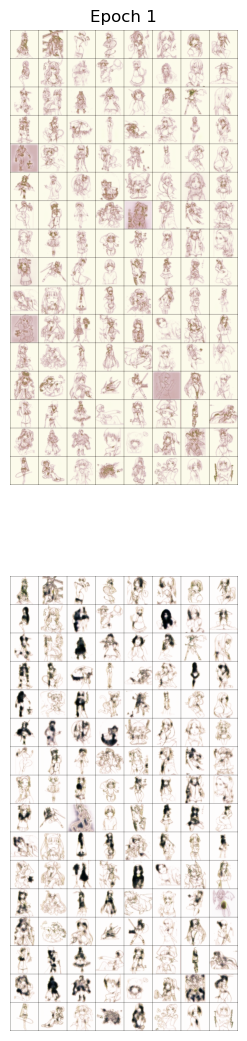

In [38]:
# visualize list of sample images
fig, axs = plt.subplots(2,1,figsize=(13,13))
[ax.imshow(img) for ax,img in zip(axs.ravel(),imgs)]
[ax.axis('off') for ax in axs.ravel()]
[ax.set_title(f'Epoch {i}') for ax, i in zip(axs.ravel(),range(1,2))];